# Deep Q Learning (Hard Pong)

In [1]:
import numpy as np
import time
import math
import random
from hard_pong_env import Env
from RL_NN import Deep_Q_Learner
from collections import deque
import matplotlib.pyplot as plt
import pickle

pygame 2.1.0 (SDL 2.0.16, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [15]:
MEMORY_SIZE = 100000 #size of the memory buffer
GAMMA = 0.95 #discount factor
ALPHA = 1e-03 #learning rate
TAU = 1e-03 #parameter for soft update
NUM_STEPS_FOR_UPDATE = 4 #update networks after C number of steps
EPSILON = 1.0 # initial epsilon for the epsilon-greedy policy
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01

In [3]:
env = Env() #loading the pong environment
env.paddle.VEL = 40
env.ball.VEL = 50
initial_state = env.reset()
initial_state

(48, 332, -41.88608839544879, 237, 39, 213, 478)

In [4]:
state_size = len(initial_state)
num_actions = 3 #(nothing, up, down)

In [5]:
# initializing the networks
nodes = [64, 64, num_actions]
activations = ['relu', 'relu', 'linear']
Q_Learner = Deep_Q_Learner(state_size, nodes, activations)

W1 shape: (64, 7)
b1 shape: (64, 1)
W2 shape: (64, 64)
b2 shape: (64, 1)
W3 shape: (3, 64)
b3 shape: (3, 1)
Total Parameters: 4867


In [6]:
def get_action(q_values, epsilon):
    if random.random() > epsilon:
        return np.argmax(q_values)
    else:
        return random.choice(np.arange(num_actions))

In [7]:
def check_update_condition(t, num_steps_upd, buffer, mini_batch_size):
    if (t+1)%num_steps_upd == 0 and len(memory_buffer) > mini_batch_size:
        return True
    else:
        return False

In [8]:
def get_experiences(buffer, size):
    if size == -1: random.shuffle(buffer)
    else: buffer = random.sample(buffer, k=size)
    states, actions, rewards, next_states, done_vals = [], [], [], [], []
    for i in buffer:
        states.append(i[0]); actions.append(i[1]); rewards.append(i[2]); next_states.append(i[3]); done_vals.append(i[4])
    states = np.array(states).T # --> shape: (state_size, m)
    actions = np.array(actions) # --> shape: (m,)
    rewards = np.array(rewards) # --> shape: (m,)
    next_states = np.array(next_states).T # --> shape: (state_size, m)
    done_vals = np.array(done_vals) # --> shape: (m,)
    return (states, actions, rewards, next_states, done_vals)

In [9]:
def get_epsilon(epsilon):
    return max(EPSILON_MIN, EPSILON_DECAY*epsilon)

## Training the Agent

![Deep Q Learning Algorithm](img/deep_q_algorithm.png)

In [10]:
start_time = time.time()

num_episodes = 20000
max_num_timesteps = 1000
mini_batch_size = 64

epsilon = EPSILON
num_p_av = 100

total_point_history = deque(maxlen=num_p_av)
avg_point_history = []
#network_cost_history = []

memory_buffer = deque(maxlen=MEMORY_SIZE)

start = time.time()
for i in range(num_episodes):
    # Reset the environment 
    state = env.reset()
    total_points = 0 

    for t in range(max_num_timesteps):
        state_qn = np.expand_dims(np.array(state), axis=1)
        q_values = Q_Learner.forward_pass(Q_Learner.train_original_param, state_qn)
        action = get_action(q_values, epsilon) #get action according to the epsilon greedy policy

        #take action
        next_state, reward, done = env.step(action)
        memory_buffer.append((state, action, reward, next_state, done))

        update = check_update_condition(t, NUM_STEPS_FOR_UPDATE, memory_buffer, mini_batch_size)

        if update:
            experiences = get_experiences(memory_buffer, size=mini_batch_size)

            Q_Learner.update_step(experiences, GAMMA, ALPHA)
            Q_Learner.update_target_network(TAU)
            #network_cost_history.append(Q_Learner.compute_cost(Q_Learner.train_original_param, get_experiences(memory_buffer, -1), GAMMA, print_opt=False)[0])

        state = next_state
        total_points += reward

        if done:
            break
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history)
    avg_point_history.append(av_latest_points)

    #update the epsilon value
    epsilon = get_epsilon(epsilon)

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    if av_latest_points > 400:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        train_time = time.time() - start
        print(f"Solved in {train_time:.2f}s")
        break

Episode 100 | Total point average of the last 100 episodes: -180.80
Episode 200 | Total point average of the last 100 episodes: 48.21
Episode 300 | Total point average of the last 100 episodes: 208.11
Episode 400 | Total point average of the last 100 episodes: 149.25
Episode 500 | Total point average of the last 100 episodes: 209.02
Episode 600 | Total point average of the last 100 episodes: 214.15
Episode 700 | Total point average of the last 100 episodes: 223.68
Episode 800 | Total point average of the last 100 episodes: 361.52
Episode 900 | Total point average of the last 100 episodes: 230.80
Episode 1000 | Total point average of the last 100 episodes: 266.95
Episode 1100 | Total point average of the last 100 episodes: 286.81
Episode 1200 | Total point average of the last 100 episodes: 287.47
Episode 1300 | Total point average of the last 100 episodes: 241.41
Episode 1400 | Total point average of the last 100 episodes: 236.02
Episode 1500 | Total point average of the last 100 episod

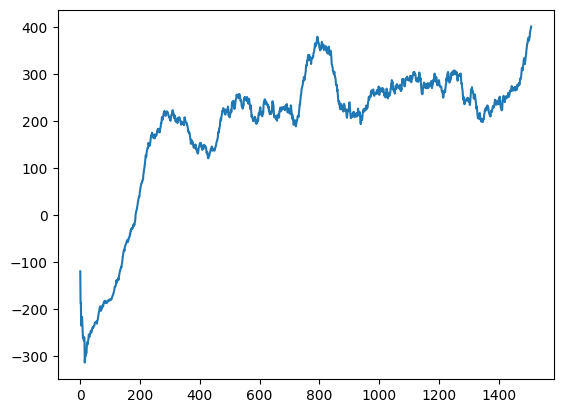

In [11]:
plt.plot(avg_point_history)

In [12]:
def save_model(model, filename):
    data = {'state_size': model.state_size, 'nodes': model.nodes, 'activations': model.activations, 'trained_original_param': model.train_original_param, 
            'trained_target_param': model.train_target_param}
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

In [1]:
#save_model(Q_Learner, 'saved_param/hard_pong_param_3.dat')